In [1]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

#emcee
import emcee
import corner as corner
import time

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.interpolate import interp1d, interp2d
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic, binned_statistic_2d

### TQDM
from tqdm import tqdm_notebook

In [2]:
def ghb_jk_teff(jk,feh):
    '''
    Calculate the photometric Teff of a star using Gonz\'{a}lez Hern\'{a}dez & Bonifacio 2009

    Input:
    -----
        jk: J - K color
    '''
    b = np.array([0.6517,0.6312,0.0168,-0.0381,0.0256,0.0013])

    theta_eff = b[0]+b[1]*jk+b[2]*(jk**2)+b[3]*(jk*feh)+b[4]*feh+b[5]*(feh**2)
    teff = 5040/theta_eff
    self.ghb_teff = teff
    return teff

def fitz_alebv(wave):
    '''
    Fitzpatrick 1999 extinction law
    '''
    recip_anchors = np.array([0.000,0.377,0.820,1.667,1.828,2.141,2.433,3.704,3.846])#[:-2]
    alebv_anchors = np.array([0.000,0.265,0.829,2.688,3.055,3.806,4.315,6.265,6.591])#[:-2]

    x=1/wave
    spl = interp1d(recip_anchors,alebv_anchors)
    alebv = spl(x)
    return alebv

leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data: data to search through 
        value: value of interest

    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

abp_ebv = ccm_alav(leff['BP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
arp_ebv = ccm_alav(leff['RP'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
aj_ebv = ccm_alav(leff['J'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ah_ebv = ccm_alav(leff['H'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))
ak_ebv = ccm_alav(leff['K'],3.1)/(ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))

# APOGEE

In [3]:
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec.fits.gz')
apoafe = dr17['ALPHA_M']+dr17['M_H']-dr17['FE_H']
apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)

# 0.659, 0.341 from Asplund et al 2021.
salfeh = dr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(dr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe_err))+0.341))*apoafe)**2)

<ipython-input-3-c08ebd709588>:3: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)


In [4]:
# https://iopscience.iop.org/article/10.3847/1538-3881/aba592/pdf

cn = dr17['FPARAM'][:,4]-dr17['FPARAM'][:,5]
dt = dr17['TEFF_SPEC'] - (4400.+552.6*(dr17['LOGG_SPEC']-2.5)-324.6*dr17['FPARAM'][:,3])

rc = dr17[np.where((dr17['FPARAM'][:,1]>2.38)&(dr17['FPARAM'][:,1]<3.5)&
                   (cn>0.04-0.46*dr17['FPARAM'][:,3]-0.0028*dt))]

rgb = dr17[np.where((dr17['FPARAM'][:,1]<3.5)&(dr17['FPARAM'][:,0]<6000.)&
                    (np.isin(dr17['APOGEE_ID'],rc['APOGEE_ID'])==False))]

rgb_salfeh = salfeh[np.where((dr17['FPARAM'][:,1]<3.5)&(dr17['FPARAM'][:,0]<6000.)&
                    (np.isin(dr17['APOGEE_ID'],rc['APOGEE_ID'])==False))]
rgb_salfeh_err = salfeh_err[np.where((dr17['FPARAM'][:,1]<3.5)&(dr17['FPARAM'][:,0]<6000.)&
                    (np.isin(dr17['APOGEE_ID'],rc['APOGEE_ID'])==False))]
rgb_apoafe = apoafe[np.where((dr17['FPARAM'][:,1]<3.5)&(dr17['FPARAM'][:,0]<6000.)&
                    (np.isin(dr17['APOGEE_ID'],rc['APOGEE_ID'])==False))]
rgb_apoafe_err = apoafe_err[np.where((dr17['FPARAM'][:,1]<3.5)&(dr17['FPARAM'][:,0]<6000.)&
                    (np.isin(dr17['APOGEE_ID'],rc['APOGEE_ID'])==False))]


# Get rid of stars with any ASPCAP flag and high extinction
rgb_salfeh[np.where((rgb['ASPCAPFLAG']==0))]
rgb_salfeh_err[np.where((rgb['ASPCAPFLAG']==0))]
rgb_apoafe[np.where((rgb['ASPCAPFLAG']==0))]
rgb_apoafe_err[np.where((rgb['ASPCAPFLAG']==0))]
rgb = rgb[np.where((rgb['ASPCAPFLAG']==0))]

# Gaia EDR3

In [5]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

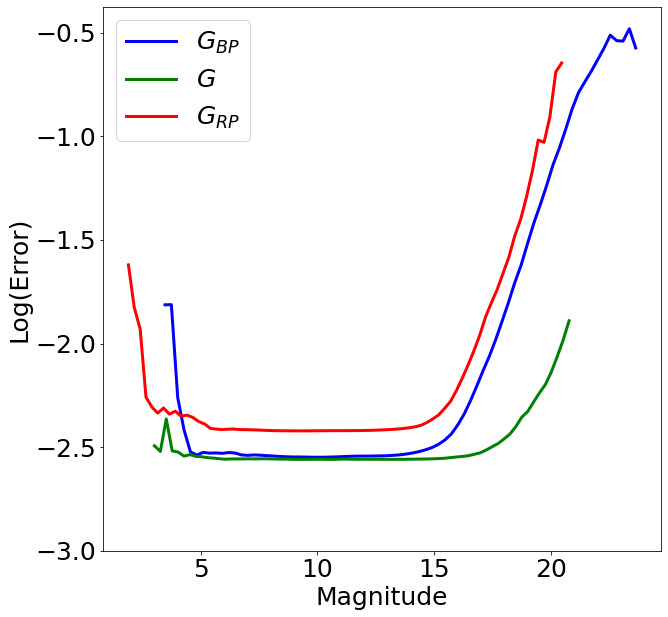

In [6]:
binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_mean_mag'])==True)

gmin = min(gaiaedr3['phot_g_mean_mag'][g_fin])
gmax = max(gaiaedr3['phot_g_mean_mag'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_mean_mag'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(gmin,gmax,gdiff/binnum),gbin,lw=3.0,c='green',label=r'$G$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)')
plt.savefig('../plots/gaiaerrorcurve.pdf',dpi=300,bbox_inches='tight');

bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
gerrfunc = IUS(np.arange(gmin,gmax,gdiff/binnum),gbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

### Replace nan's with zeropoint error
bperr = np.nan_to_num(10**bperrfunc(rgb['GAIAEDR3_PHOT_BP_MEAN_MAG']),nan=0.0027901700)
gerr = np.nan_to_num(10**gerrfunc(rgb['GAIAEDR3_PHOT_G_MEAN_MAG']),nan=0.0027553202)
rperr = np.nan_to_num(10**rperrfunc(rgb['GAIAEDR3_PHOT_RP_MEAN_MAG']),nan=0.0037793818)

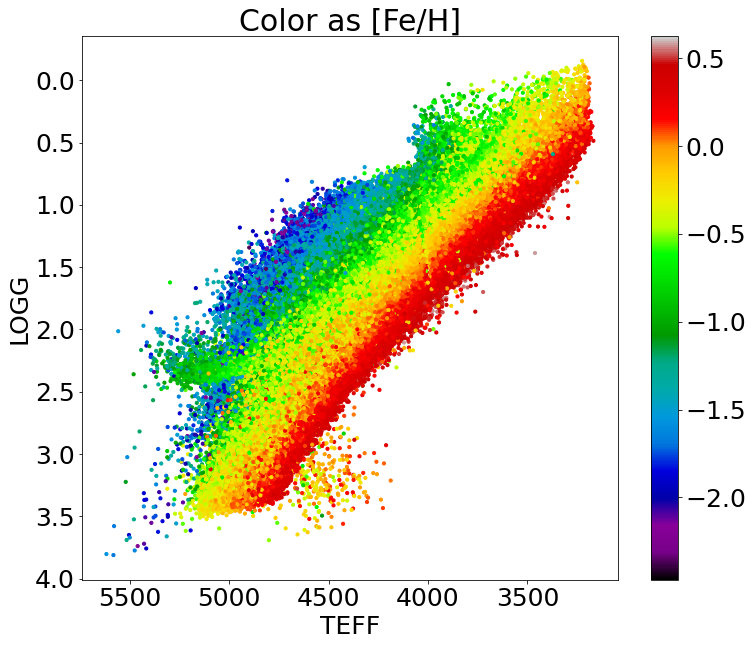

In [7]:
plt.figure(figsize=[12,10])
plt.scatter(rgb['TEFF'],rgb['LOGG'],c=rgb['FE_H'],cmap='nipy_spectral',s=10)
plt.colorbar()

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'TEFF')
plt.ylabel(r'LOGG');

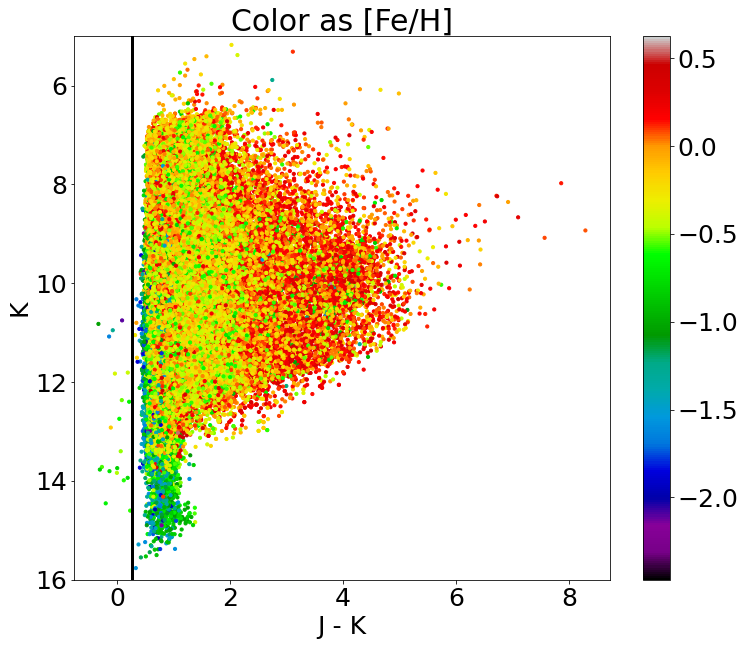

In [15]:
plt.figure(figsize=[12,10])
plt.scatter(rgb['J']-rgb['K'],rgb['K'],c=rgb['FE_H'],cmap='nipy_spectral',s=10)
plt.axvline(0.25,c='k',lw=3.0)
plt.colorbar()

plt.ylim(5,16)

# plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'J - K')
plt.ylabel(r'K');

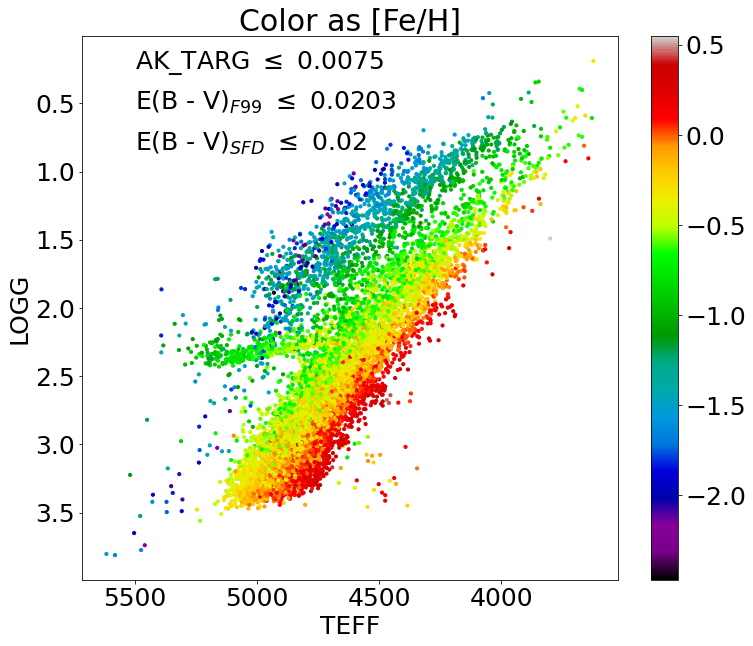

In [8]:
low_ak = np.where((rgb['AK_TARG']<=0.0075)&(rgb['SFD_EBV']<=0.02)&(rgb['J']-rgb['K']>0.25))

plt.figure(figsize=[12,10])
plt.scatter(rgb['TEFF'][low_ak],rgb['LOGG'][low_ak],c=rgb['FE_H'][low_ak],cmap='nipy_spectral',s=10)
plt.colorbar()

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.text(5500,0.25,r'AK_TARG $\leq$ 0.0075')
plt.text(5500,0.55,r'E(B - V)$_{F99}$ $\leq$ 0.0203')
plt.text(5500,0.85,r'E(B - V)$_{SFD}$ $\leq$ 0.02')

plt.title(r'Color as [Fe/H]')
plt.xlabel(r'TEFF')
plt.ylabel(r'LOGG');

In [16]:
len(np.squeeze(low_ak))

9927